In [1]:
#RNN(recurrent neural network Daily)

import numpy as np
import pandas as pd
from pathlib import Path
import statsmodels.api as sm
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from statsmodels.tsa.stattools import adfuller
import itertools
import datetime
import warnings
import statsmodels.api as sm
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import pandas as pd
from prophet import Prophet
from prophet.plot import plot_plotly, plot_components_plotly
from statsmodels.tsa.seasonal import seasonal_decompose
from hijri_converter import convert
import holidays


import warnings

import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
%matplotlib inline

In [28]:
df = pd.read_excel("D://Khalid//Magang//PELNI_RevenueRegression//Revenue-Regression//revenueDaily.xlsx")
df = df.rename(columns={'tanggal': 'date'})
df['date'] = pd.to_datetime(df['date'], format='%Y-%m-%d')
df = df.rename(columns={'penghasilan_muatan': 'y'}) #RENAME KOLOM REVENUE MENJADI y

# Drop the original date column
# df = df.drop('date', axis=1)
# df = df.set_index('date')
# df = df.sort_index()

df

,y,date,org,kode_org,des,kode_des
0,1014634.0,2023-01-18,AGATS,948,BAU-BAU,921
1,62486.0,2023-01-13,AGATS,948,KUPANG,681
2,1232000.0,2022-02-16,AGATS,948,MAKASSAR,893
3,344312.0,2023-02-11,AGATS,948,MERAUKE,979
4,344312.0,2023-01-18,AGATS,948,MERAUKE,979
...,...,...,...,...,...,...
21225,2324074.0,2022-09-24,WASIOR,981,TANJUNG PRIOK,431
21226,3600595.0,2023-03-26,WASIOR,981,TANJUNG PRIOK,431
21227,2324073.0,2023-02-26,WASIOR,981,TANJUNG PRIOK,431
21228,2325000.0,2022-01-01,WASIOR,981,TANJUNG PRIOK,431


In [29]:
# data = df.loc[(df['kode_des']==431)] #ambil data by destination doang
# data = data.groupby(['date','year','month','day', 'weekday', 'weekofmonth', 'hijri_year', 'hijri_month', 'hijri_day'])['y'].sum()

# data = pd.DataFrame(data)
# data

df = df.groupby(['kode_des', 'date'], as_index=False)['y'].sum()
df

,kode_des,date,y
0,144,2020-12-30,20000.0
1,144,2021-03-26,59000.0
2,144,2021-05-21,47000.0
3,144,2021-06-18,186000.0
4,144,2021-07-02,93000.0
...,...,...,...
13412,983,2023-03-18,1338994.0
13413,983,2023-03-21,414963.0
13414,983,2023-03-25,8095625.0
13415,983,2023-03-27,600099.0


In [30]:
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['weekday'] = df['date'].dt.weekday
df['weekofmonth'] = df['date'].apply(lambda x: (x.day-1) // 7 + 1) # calculate week of month
df['hijri_year'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().year)
df['hijri_month'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().month)
df['hijri_day'] = df['date'].apply(lambda x: convert.Gregorian(x.year, x.month, x.day).to_hijri().day)

df

,kode_des,date,y,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day
0,144,2020-12-30,20000.0,2020,12,30,2,5,1442,5,15
1,144,2021-03-26,59000.0,2021,3,26,4,4,1442,8,13
2,144,2021-05-21,47000.0,2021,5,21,4,3,1442,10,9
3,144,2021-06-18,186000.0,2021,6,18,4,3,1442,11,8
4,144,2021-07-02,93000.0,2021,7,2,4,1,1442,11,22
...,...,...,...,...,...,...,...,...,...,...,...
13412,983,2023-03-18,1338994.0,2023,3,18,5,3,1444,8,26
13413,983,2023-03-21,414963.0,2023,3,21,1,3,1444,8,29
13414,983,2023-03-25,8095625.0,2023,3,25,5,4,1444,9,3
13415,983,2023-03-27,600099.0,2023,3,27,0,4,1444,9,5


In [32]:
id_holidays = holidays.ID(years=range(2020, 2024))

data = []

for day, event in id_holidays.items():
    data.append({'day': day, 'event': event})
    
df_holidays = pd.DataFrame(data)
df_holidays['day'] = pd.to_datetime(df_holidays['day'], format='%Y/%m/%d')
df_holidays

,day,event
0,2020-12-09,Hari Pemilihan
1,2020-01-01,Tahun Baru Masehi
2,2020-01-25,Tahun Baru Imlek
3,2020-03-25,Hari Suci Nyepi
4,2020-05-24,Hari Raya Idul Fitri
...,...,...
59,2023-05-01,Hari Buruh Internasional
60,2023-05-18,Kenaikan Yesus Kristus
61,2023-06-01,Hari Lahir Pancasila
62,2023-08-17,Hari Kemerdekaan Republik Indonesia


In [33]:
df['is_holiday']=df['date'].apply(lambda x: 1 if x in df_holidays['day'].values else 0)
df.loc[df['is_holiday']==1]

,kode_des,date,y,year,month,day,weekday,weekofmonth,hijri_year,hijri_month,hijri_day,is_holiday
14,144,2022-04-15,80000.0,2022,4,15,4,3,1443,9,14,1
46,246,2022-12-25,102905.0,2022,12,25,6,4,1444,6,1,1
60,251,2022-01-01,628000.0,2022,1,1,5,1,1443,5,28,1
83,251,2022-06-01,63573.0,2022,6,1,2,1,1443,11,2,1
93,251,2022-07-30,408822.0,2022,7,30,5,5,1444,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...
13257,983,2022-03-03,1888000.0,2022,3,3,3,1,1443,7,30,1
13301,983,2022-07-10,427477.0,2022,7,10,6,2,1443,12,11,1
13310,983,2022-07-30,159721.0,2022,7,30,5,5,1444,1,1,1
13317,983,2022-08-17,19909311.0,2022,8,17,2,3,1444,1,19,1


In [34]:

data = df.loc[df['kode_des'] == 431]
data = data.groupby(['date','year','month','day', 'weekday', 'weekofmonth','hijri_month', 'hijri_day', 'hijri_year','is_holiday'])['y'].sum()

data = pd.DataFrame(data)

data = data.reset_index()
data = data.set_index('date')

# # Resample to weekly frequency
data = data.resample('W').sum()
data = data.reset_index()
data = data.set_index(['year','month','day', 'weekday', 'weekofmonth','hijri_month', 'hijri_day', 'hijri_year','is_holiday'])
data = data.drop('date', axis =1 )
data

y
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday             
2020  11    18  2       3           4           3         1442       0            21891600.0
8080  44    109 17      17          16          49        5768       0            82167900.0
4040  23    32  2       6           8           32        2884       0            25570700.0
      24    24  10      4           8           54        2884       0            33002000.0
6060  36    45  3       8           13          60        4326       0            81230000.0
...                                                                                      ...
12138 18    53  17      10          48          101       8664       0           589943335.0
            96  18      16          48          144       8664       0           142535977.0
14161 21    161 21      26          60          97        10108      1           785915116.0
8092  13    85  8       14          36          28        5776       0           250352469.0
2023  4     9   6       2           9           18        1444       0             1510000.0

[125 rows x 1 columns]

In [35]:
#ELIMINASI OUTLIERS
#Deteksi pakai Interquartile Range (IQR):
Q1 = data.quantile(0.25)
Q3 = data.quantile(0.75)
IQR = Q3 - Q1

# Remove outliers using the IQR method
data = data[~((data < (Q1 - 1.5 * IQR)) | (data > (Q3 + 1.5 * IQR))).any(axis=1)]
data

y
year  month day weekday weekofmonth hijri_month hijri_day hijri_year is_holiday             
2020  11    18  2       3           4           3         1442       0            21891600.0
8080  44    109 17      17          16          49        5768       0            82167900.0
4040  23    32  2       6           8           32        2884       0            25570700.0
      24    24  10      4           8           54        2884       0            33002000.0
6060  36    45  3       8           13          60        4326       0            81230000.0
...                                                                                      ...
12138 18    53  17      10          48          101       8664       0           589943335.0
            96  18      16          48          144       8664       0           142535977.0
14161 21    161 21      26          60          97        10108      1           785915116.0
8092  13    85  8       14          36          28        5776       0           250352469.0
2023  4     9   6       2           9           18        1444       0             1510000.0

[124 rows x 1 columns]

In [36]:
# Interpolate missing values
data_interpolated = data.interpolate()

# Check if there are any remaining missing values
print(data_interpolated.isnull().sum())

y    0
dtype: int64


In [37]:
len(data)

124

In [38]:
steps = 28
train = data[:-steps]
test  = data[-steps:]

In [39]:
#MINMAXSCALER
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(train)
scaled_train = scaler.transform(train)
scaled_test = scaler.transform(test)



In [40]:
scaled_train[:10]

array([[0.02638148],
       [0.0990202 ],
       [0.03081514],
       [0.03977057],
       [0.09788994],
       [0.00697618],
       [0.11014643],
       [0.        ],
       [0.10328744],
       [0.02638148]])

In [41]:
from keras.preprocessing.sequence import TimeseriesGenerator

In [42]:
# We do the same thing, but now instead for 12 months
n_input = 12
n_features = 1
generator = TimeseriesGenerator(scaled_train, scaled_train, length=n_input, batch_size=1)

In [43]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM

# define model
model = Sequential()
model.add(LSTM(100, activation='relu', input_shape=(n_input, n_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mse')

In [44]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 100)               40800     
                                                                 
 dense_1 (Dense)             (None, 1)                 101       
                                                                 
Total params: 40,901
Trainable params: 40,901
Non-trainable params: 0
_________________________________________________________________


In [45]:
# fit model
model.fit(generator,epochs=50)

Epoch 1/50
84/84 [==============================] - 3s 4ms/step - loss: 0.0627
Epoch 2/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0376
Epoch 3/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0381
Epoch 4/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0343
Epoch 5/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0357
Epoch 6/50
84/84 [==============================] - 1s 6ms/step - loss: 0.0347
Epoch 7/50
84/84 [==============================] - 0s 4ms/step - loss: 0.0318
Epoch 8/50
84/84 [==============================] - 1s 6ms/step - loss: 0.0330
Epoch 9/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0337
Epoch 10/50
84/84 [==============================] - 0s 6ms/step - loss: 0.0315
Epoch 11/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0315
Epoch 12/50
84/84 [==============================] - 0s 5ms/step - loss: 0.0319
Epoch 13/50
84/84 [==============================

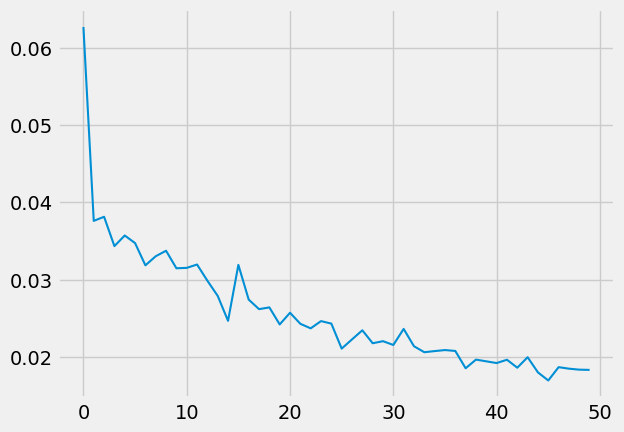

In [46]:
loss_per_epoch = model.history.history['loss']
plt.plot(range(len(loss_per_epoch)),loss_per_epoch)

In [47]:
last_train_batch = scaled_train[-12:]

last_train_batch = last_train_batch.reshape((1, n_input, n_features))

model.predict(last_train_batch)

1/1 [==============================] - 0s 276ms/step


array([[0.38790336]], dtype=float32)

In [48]:
scaled_test[0]

test_predictions = []

first_eval_batch = scaled_train[-n_input:]
current_batch = first_eval_batch.reshape((1, n_input, n_features))

for i in range(len(test)):
    
    # get the prediction value for the first batch
    current_pred = model.predict(current_batch)[0]
    
    # append the prediction into the array
    test_predictions.append(current_pred) 
    
    # use the prediction to update the batch and remove the first value
    current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)

1/1 [==============================] - 0s 26ms/step


In [49]:
test_predictions

[array([0.38790336], dtype=float32),
 array([0.37100637], dtype=float32),
 array([0.4350092], dtype=float32),
 array([0.3483969], dtype=float32),
 array([0.4721389], dtype=float32),
 array([0.32374546], dtype=float32),
 array([0.49091426], dtype=float32),
 array([0.3164084], dtype=float32),
 array([0.48900348], dtype=float32),
 array([0.330364], dtype=float32),
 array([0.45962143], dtype=float32),
 array([0.35046414], dtype=float32),
 array([0.43653357], dtype=float32),
 array([0.36499915], dtype=float32),
 array([0.43143433], dtype=float32),
 array([0.36751086], dtype=float32),
 array([0.43615752], dtype=float32),
 array([0.36188257], dtype=float32),
 array([0.44447294], dtype=float32),
 array([0.35535035], dtype=float32),
 array([0.45034462], dtype=float32),
 array([0.35300633], dtype=float32),
 array([0.44781926], dtype=float32),
 array([0.3565388], dtype=float32),
 array([0.44066572], dtype=float32),
 array([0.3631037], dtype=float32),
 array([0.4341197], dtype=float32),
 array([0.

In [50]:
test.head()

,,,,,,,,,y
year,month,day,weekday,weekofmonth,hijri_month,hijri_day,hijri_year,is_holiday,
14154,63,154,21,25,14,182,10108,0,270694518.0
12132,56,117,21,20,18,21,8664,0,252625603.0
14154,70,42,21,9,21,70,10108,1,397294789.0
12132,60,79,19,14,18,103,8664,0,299681740.0
14154,70,140,21,23,21,168,10108,0,558172460.0


In [51]:
true_predictions = scaler.inverse_transform(test_predictions)

In [52]:
test.loc[:, 'Predictions'] = true_predictions
test.head()

C:\Users\khali\AppData\Local\Temp\ipykernel_8260\1567470468.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.loc[:, 'Predictions'] = true_predictions


,,,,,,,,,y,Predictions
year,month,day,weekday,weekofmonth,hijri_month,hijri_day,hijri_year,is_holiday,,
14154,63,154,21,25,14,182,10108,0,270694518.0,3.218859e+08
12132,56,117,21,20,18,21,8664,0,252625603.0,3.078646e+08
14154,70,42,21,9,21,70,10108,1,397294789.0,3.609748e+08
12132,60,79,19,14,18,103,8664,0,299681740.0,2.891031e+08
14154,70,140,21,23,21,168,10108,0,558172460.0,3.917854e+08


<Axes: xlabel='year,month,day,weekday,weekofmonth,hijri_month,hijri_day,hijri_year,is_holiday'>

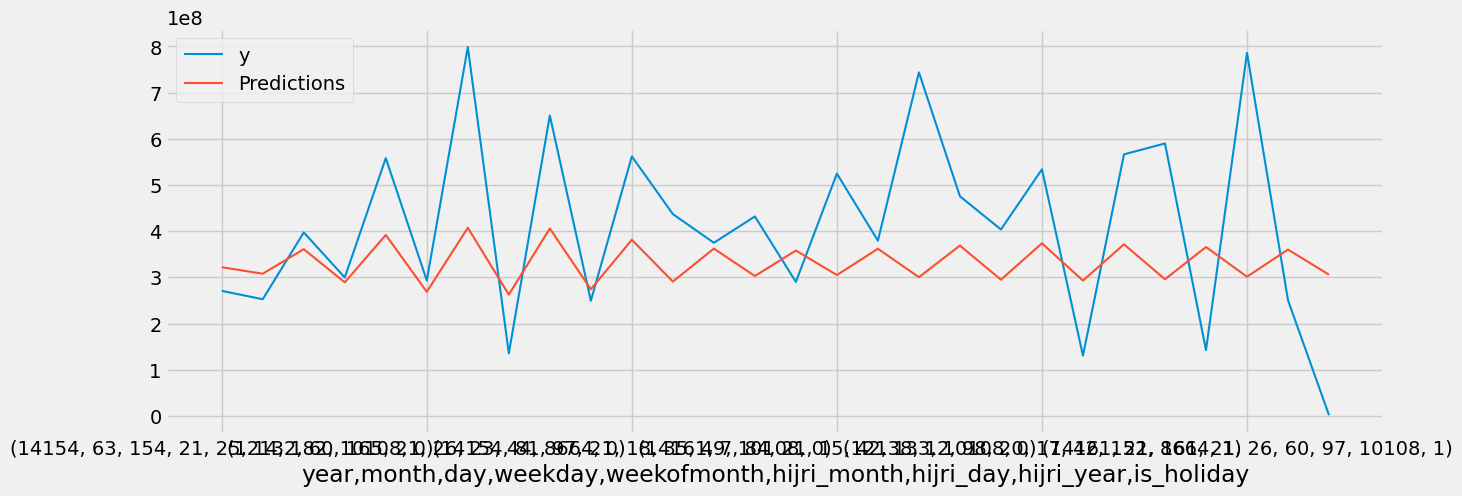

In [53]:
test.plot(figsize=(14,5))

In [54]:
from sklearn.metrics import mean_squared_error
from math import sqrt
rmse=sqrt(mean_squared_error(test['y'],test['Predictions']))
print("Root Mean Square Error (RMSE):", rmse) 
print("Mean Value of Test Dataset:", test['y'].mean())

Root Mean Square Error (RMSE): 204855023.6689902
Mean Value of Test Dataset: 411774556.89285713
